In [1]:
import os
import sys
import glob
import pickle
import itertools
import random

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm
from sklearn import mixture


from flowMP import *

random.seed(1234)
%matplotlib inline

## Simulate data

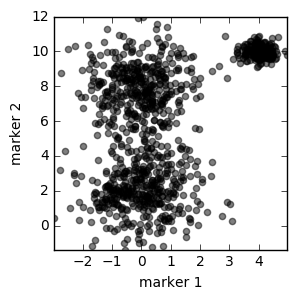

In [2]:
means = [[0, 2],[0,8],[4,10]]
covs = [[[1, 0], [0, 2]],[[1, 0], [0, 2]] ,[[0.1, 0], [0, 0.1]]]
n_samples = [400,400,200]
data = np.concatenate([np.random.multivariate_normal(means[i], covs[i], n_samples[i]) for i in range(3)])
plt.figure(figsize=(3,3))
plt.scatter(data[:,0],data[:,1],c='k',alpha=0.5,s=20)
plt.xlabel('marker 1')
plt.ylabel('marker 2')
plt.xlim(data[:,0].min(),data[:,0].max())
plt.ylim(data[:,1].min(),data[:,1].max())
plt.show()

## Given #cell-types = 2, classify cells with Gaussian mixture models

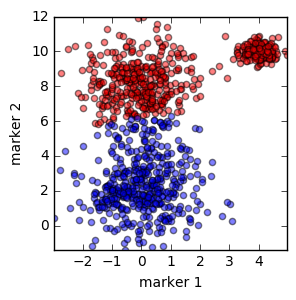

In [6]:
g = mixture.GaussianMixture(n_components=2)
g.fit(data)
y_pred = g.predict(data)

plt.figure(figsize=(3,3))
plt.scatter(data[y_pred==0][:,0],data[y_pred==0][:,1],c= 'r',alpha=0.5,s=20)
plt.scatter(data[y_pred==1][:,0],data[y_pred==1][:,1],c= 'b',alpha=0.5,s=20)
plt.xlabel('marker 1')
plt.ylabel('marker 2')
plt.xlim(data[:,0].min(),data[:,0].max())
plt.ylim(data[:,1].min(),data[:,1].max())
plt.show()

## A scientist provided us prior information

In [7]:
table = pd.DataFrame({'marker1': [-1, 1], 'marker2': [0, 1]})
table.index = ['cell-type A', 'cell-type B']
table

,marker1,marker2
cell-type A,-1,0
cell-type B,1,1


### Randomly draw a cut on marker 1 dimension.

cut position $cut \sim Beta(\alpha, \beta)$, $\alpha = 2, \beta = 2$. After partitioning the data space into 2 parts:
$x^{left} \sim N(\mu^{left},\Sigma^{left})$ and $x^{right} \sim N(\mu^{right},\Sigma^{right})$

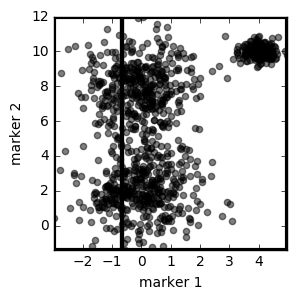

In [9]:
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])
sample = draw_informed_Mondrian(theta_space, table)

plt.figure(figsize=(3,3))
plt.scatter(data[:,0],data[:,1],c='k',alpha=0.5,s=20)
plt.xlabel('marker 1')
plt.ylabel('marker 2')
print_partitions(sample)
plt.xlim(data[:,0].min(),data[:,0].max())
plt.ylim(data[:,1].min(),data[:,1].max())
plt.show()
plt.show()

### Posterior samples of cuts selected with MCMC

In [10]:
%%time

n_mcmc_chain = 1
n_mcmc_sample = 1000
mcmc_gaussin_std = 0.1 # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, data) + \
                     comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
        

        if (idx+1) % 10000 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

Drawing Chain 0 ...
Total number of accepted samples: 39
CPU times: user 1.64 s, sys: 2.34 ms, total: 1.64 s
Wall time: 1.64 s


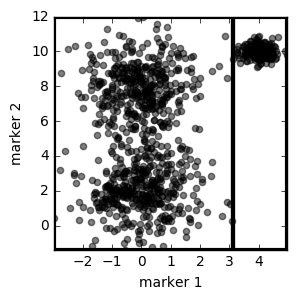

In [12]:
plt.figure(figsize=(3,3))
plt.scatter(data[:,0],data[:,1],c='k',alpha=0.5,s=20)
plt.xlabel('marker 1')
plt.ylabel('marker 2')
print_partitions(accepts[0][-1])
plt.xlim(data[:,0].min(),data[:,0].max())
plt.ylim(data[:,1].min(),data[:,1].max())
plt.show()